Uses elegy instead of flax.

### Load libraries

In [1]:
import elegy as eg
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax

jnp.arange(0)  # Prints out any jax warnings.

DeviceArray([], dtype=int32)

### Define generator neural network

In [2]:
class MLP(eg.Module):
    def __init__(self, layer_widths: tuple[int], **kwargs):
        super().__init__(**kwargs)
        self.layer_widths = layer_widths

    @eg.compact
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        for w in self.layer_widths[:-1]:
            x = eg.Linear(
                w,
                kernel_init=eg.initializers.he_normal(),
            )(x)
            x = jax.nn.relu(x)

        x = eg.Linear(
            self.layer_widths[-1],
            kernel_init=eg.initializers.he_normal(),
        )(x)
        return x

In [3]:
def get_random_model(
    input_shape: tuple[int] = (2,),
    layer_widths: tuple[int, ...] = (96, 192, 1),
    seed: int = 0,
) -> eg.Model:
    """
    [96, 192, 1] is from https://arxiv.org/pdf/2102.06701.pdf.
    """
    model = eg.Model(
        module=MLP(layer_widths=layer_widths),
        seed=seed,
    )
    
    assert not model.initialized
    model.predict(jnp.zeros(input_shape))
    assert model.initialized
    
    return model


get_random_model(seed=42).summary()

┏━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path     ┃ module   ┃ params                              ┃ Parameter      ┃
┡━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ *        │ MLP()    │                                     │                │
├──────────┼──────────┼─────────────────────────────────────┼────────────────┤
│ .linear  │ Linear() │ bias: Parameter(96)         float32 │ 288     1.2KB  │
│          │          │ kernel: Parameter(2, 96)    float32 │                │
├──────────┼──────────┼─────────────────────────────────────┼────────────────┤
│ .linear2 │ Linear() │ bias: Parameter(192)        float32 │ 18,624  74.5KB │
│          │          │ kernel: Parameter(96, 192)  float32 │                │
├──────────┼──────────┼─────────────────────────────────────┼────────────────┤
│ .linear3 │ Linear() │ bias: Parameter(1)          float32 │ 193     772B   │
│          │          │ kernel: Parameter(192, 1)   float32 │                │
├──────────┼──────────┼─────────────────────────────────────┼────────────────┤
│          │          │                              Total: │ 19,105  76.4KB │
└──────────┴──────────┴─────────────────────────────────────┴────────────────┘
                                                                              
                       Total Parameters: 19,105  76.4KB                       

### Visualize neural net as image

In [4]:
def unit_sq_sampling(side_samples: int):
    xs, ys = jnp.meshgrid(
        jnp.linspace(-1, 1, side_samples),
        jnp.linspace(-1, 1, side_samples),
    )
    return jnp.stack([xs, ys]).T
    
unit_sq_sampling(30).shape

(30, 30, 2)

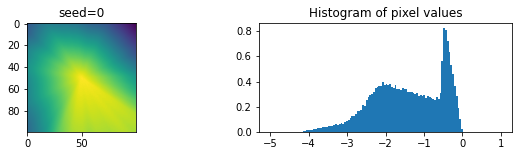

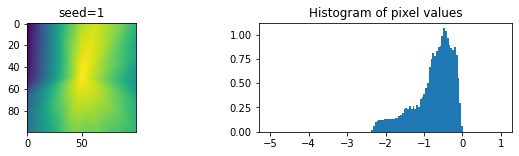

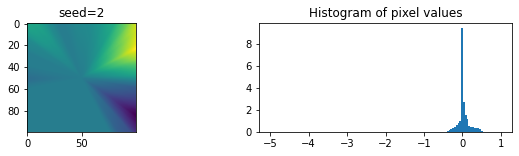

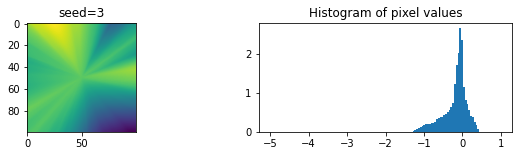

In [5]:
def get_model_img(
    model: eg.Model,
    side_samples: int,
) -> jnp.ndarray:
    XY = unit_sq_sampling(side_samples)
    assert XY.shape == (side_samples, side_samples, 2)

    return model.predict(XY).squeeze(-1)


for seed in range(4):
    model = get_random_model(
        layer_widths=[96, 192, 32, 4, 1],
        seed=seed,
    )

    img = get_model_img(model=model, side_samples=100)

    plt.figure(figsize=(10, 2))

    plt.subplot(1, 2, 1)
    plt.title(f"{seed=}")
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.title("Histogram of pixel values")
    plt.hist(img.flatten(), bins=128, range=(-5, 1), density=True)

    plt.show();

## DFT and DCT

In [6]:
def get_shifted_dft(img: jnp.ndarray) -> jnp.ndarray:
    """
    If img is NxN, then
    img[x, y] = sum_{a, b} dft[a, b] * exp(2 * pi * i * (a * x + b * y) / N)
    """

    dft = jnp.fft.fft2(img) / img.size  # Normalize by size
    shifted_dft = jnp.roll(
        jnp.roll(dft, img.shape[0] // 2, axis=0),
        img.shape[0] // 2,
        axis=1,
    )
    return shifted_dft


def get_shifted_dct2(img: jnp.ndarray) -> jnp.ndarray:
    dct = jax.scipy.fft.dct(
        jax.scipy.fft.dct(img.T, norm="ortho").T,
        norm="ortho",
    )
    shifted_dct = jnp.roll(
        jnp.roll(dct, img.shape[0] // 2, axis=0),
        img.shape[0] // 2,
        axis=1,
    )
    return shifted_dct

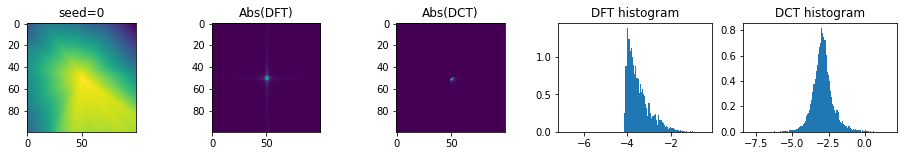

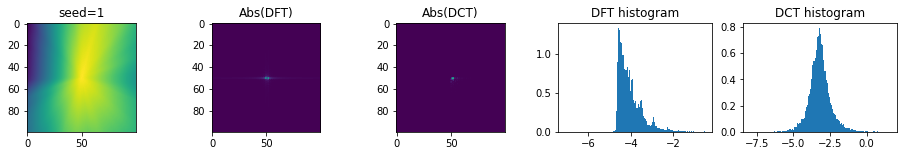

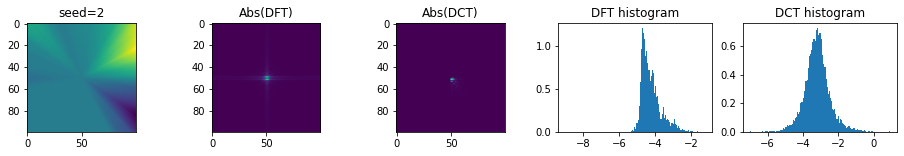

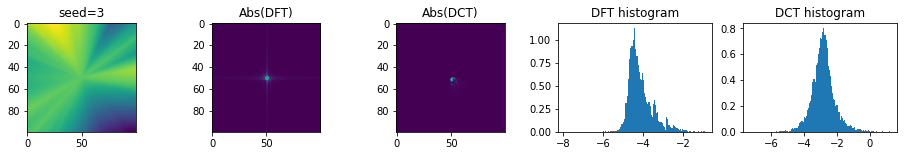

In [7]:
for seed in range(4):
    model = get_random_model(
        layer_widths=[96, 192, 32, 4, 1],
        seed=seed,
    )

    img = get_model_img(model=model, side_samples=100)
    img = img - img.mean()

    sdft = get_shifted_dft(img)
    sdct = get_shifted_dct2(img)

    plt.figure(figsize=(16, 2))
    plt.subplot(1, 5, 1)
    plt.title(f"{seed=}")
    plt.imshow(img)

    plt.subplot(1, 5, 2)
    plt.title("Abs(DFT)")
    plt.imshow(jnp.abs(sdft))
    
    plt.subplot(1, 5, 3)
    plt.title("Abs(DCT)")
    plt.imshow(jnp.abs(sdct))

    plt.subplot(1, 5, 4)
    plt.title("DFT histogram")
    plt.hist(
        jnp.log10(jnp.abs(sdft).flatten()),
        bins=128,
        density=True,
    );
    
    plt.subplot(1, 5, 5)
    plt.title("DCT histogram")
    plt.hist(
        jnp.log10(jnp.abs(sdct).flatten()),
        bins=128,
        density=True,
    );

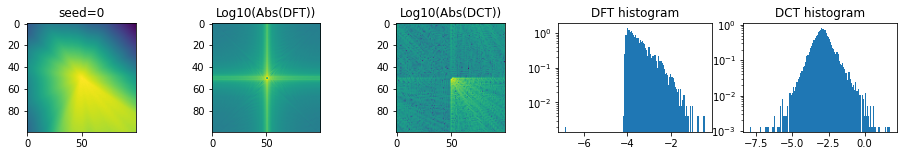

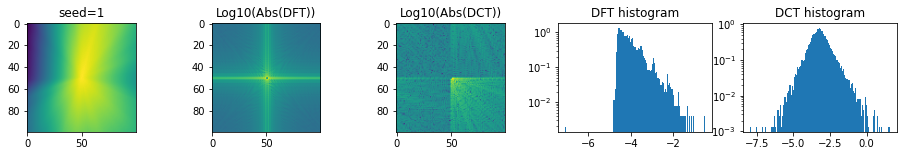

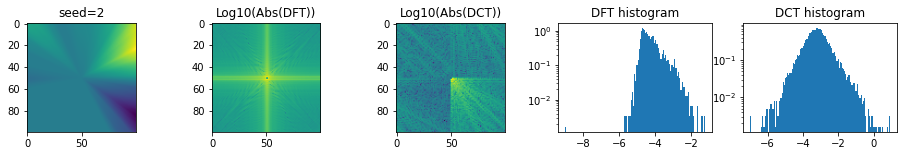

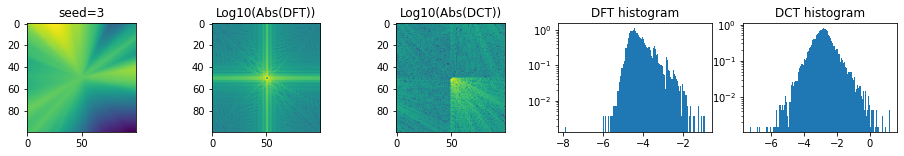

In [8]:
for seed in range(4):
    model = get_random_model(
        layer_widths=[96, 192, 32, 4, 1],
        seed=seed,
    )

    img = get_model_img(model=model, side_samples=100)
    img = img - img.mean()

    sdft = get_shifted_dft(img)
    sdct = get_shifted_dct2(img)

    plt.figure(figsize=(16, 2))
    plt.subplot(1, 5, 1)
    plt.title(f"{seed=}")
    plt.imshow(img)

    plt.subplot(1, 5, 2)
    plt.title("Log10(Abs(DFT))")
    plt.imshow(jnp.log10(jnp.abs(sdft)))
    
    plt.subplot(1, 5, 3)
    plt.title("Log10(Abs(DCT))")
    plt.imshow(jnp.log10(jnp.abs(sdct)))

    plt.subplot(1, 5, 4)
    plt.title("DFT histogram")
    plt.yscale("log")
    plt.hist(
        jnp.log10(jnp.abs(sdft).flatten()),
        bins=128,
        density=True,
    );
    
    plt.subplot(1, 5, 5)
    plt.title("DCT histogram")
    plt.yscale("log")
    plt.hist(
        jnp.log10(jnp.abs(sdct).flatten()),
        bins=128,
        density=True,
    );

# Conclusions
Randomly initialized neural networks of the type
$\mathbb{R}^2 \to \mathbb{R}$
are pretty low-frequency.